# Student Notes Prediction (XGB+LGBM+Cat)

## Import

In [6]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import os

## get data

In [7]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
sample = pd.read_csv("./data/sample_submission.csv")

score = train['exam_score'] 

## Format Data

In [ ]:
def kfold_target(df_train, df_test, colonne_cat, colonne_target):

    kf = KFold(n_splits=20, shuffle=True, random_state=42)
    
    new_col = colonne_cat + "_val"

    df_train[new_col] = np.nan
    
    for index_professeurs, index_eleves in kf.split(df_train):
    
        donnees_profs = df_train.iloc[index_professeurs]
        donnees_eleves = df_train.iloc[index_eleves]
        moyennes = donnees_profs.groupby(colonne_cat)[colonne_target].mean()
    
        df_train.loc[index_eleves, new_col] = donnees_eleves[colonne_cat].map(moyennes)
    
    moyenne_globale = df_train[colonne_target].mean()
    df_train[new_col] = df_train[new_col].fillna(moyenne_globale)

    moyennes_finales = df_train.groupby(colonne_cat)[colonne_target].mean()
    df_test[new_col] = df_test[colonne_cat].map(moyennes_finales).fillna(moyenne_globale)
    
    return df_train, df_test

# sleep_quality
train['sleep_quality'] = train['sleep_quality'].fillna("None")
test['sleep_quality'] = test['sleep_quality'].fillna("None")

sleep_quality_map = {
    "None": 0,
    "poor" : 1,
    "average" : 2,
    "good" : 3
}

train["sleep_quality_val"] = train["sleep_quality"].map(sleep_quality_map)
test["sleep_quality_val"] = test["sleep_quality"].map(sleep_quality_map)

train = train.drop('sleep_quality', axis=1)
test = test.drop('sleep_quality', axis=1)

# facility_rating
train['facility_rating'] = train['facility_rating'].fillna("None")
test['facility_rating'] = test['facility_rating'].fillna("None")

facility_rating_map = {
    "None": 0,
    "low" : 1,
    "medium" : 2,
    "high" : 3
}

train["facility_rating_val"] = train["facility_rating"].map(facility_rating_map)
test["facility_rating_val"] = test["facility_rating"].map(facility_rating_map)

train = train.drop('facility_rating', axis=1)
test = test.drop('facility_rating', axis=1)

# adjusted_study

train['exam_difficulty'] = train['exam_difficulty'].fillna("None")
test['exam_difficulty'] = test['exam_difficulty'].fillna("None")

train, test = kfold_target(train, test, 'exam_difficulty', 'exam_score')


train['adjusted_study'] = train['study_hours'] * train['exam_difficulty_val']
test['adjusted_study'] = test['study_hours'] * test['exam_difficulty_val']

# adjusted_class_attendance

train = train.drop('exam_difficulty', axis=1)
test = test.drop('exam_difficulty', axis=1)

train['adjusted_class_attendance'] = train['class_attendance'] * train['exam_difficulty_val']
test['adjusted_class_attendance'] = test['class_attendance'] * test['exam_difficulty_val']

# study method 

train['study_method'] = train['study_method'].fillna("None")
test['study_method'] = test['study_method'].fillna("None")

train, test = kfold_target(train, test, 'study_method', 'exam_score')

train = train.drop('study_method', axis=1)
test = test.drop('study_method', axis=1)

# gender 

train['gender'] = train['gender'].fillna("None")
test['gender'] = test['gender'].fillna("None")

train, test = kfold_target(train, test, 'gender', 'exam_score')

train = train.drop('gender', axis=1)
test = test.drop('gender', axis=1)

# internet 

train['internet_access'] = train['internet_access'].fillna("None")
test['internet_access'] = test['internet_access'].fillna("None")

train, test = kfold_target(train, test, 'internet_access', 'exam_score')

train = train.drop('internet_access', axis=1)
test = test.drop('internet_access', axis=1)

# course 
train['course'] = train['course'].fillna("None")
test['course'] = test['course'].fillna("None")

train, test = kfold_target(train, test, 'course', 'exam_score')

train = train.drop('course', axis=1)
test = test.drop('course', axis=1)


# study and class
train["study_and_class_work"] = train["study_hours"] + train["class_attendance"]
test["study_and_class_work"] = test["study_hours"] + test["class_attendance"]

train['log_study_hours'] = np.log1p(train['study_hours'])
test['log_study_hours'] = np.log1p(test['study_hours'])

train['efficiency_score'] = train['study_hours'] * train['sleep_hours']
test['efficiency_score'] = test['study_hours'] * test['sleep_hours']

train['log_adjusted_study'] = train['log_study_hours'] * train['exam_difficulty_val']
test['log_adjusted_study'] = test['log_study_hours'] * test['exam_difficulty_val']

# clean final datasets

train = pd.get_dummies(train, dtype=int)
test = pd.get_dummies(test, dtype=int)

train, test = train.align(test, join='inner', axis=1)

train = train.fillna(train.mean())
test = test.fillna(test.mean())

train = train.drop('id', axis=1, errors='ignore')
test = test.drop('id', axis=1, errors='ignore')


In [ ]:
def objective_cat(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'iterations': trial.suggest_int('iterations', 1000, 3000), 
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        # Constant params
        'random_seed': 42,
        'verbose': 0,
        'allow_writing_files': False,
        'loss_function': 'RMSE'
    }
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_list = []
    
    for train_idx, val_idx in kf.split(train):
        X_tr, X_val = train.iloc[train_idx], train.iloc[val_idx]
        y_tr, y_val = score.iloc[train_idx], score.iloc[val_idx]
        
        model = CatBoostRegressor(**params)
        model.fit(X_tr, y_tr)
        
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_list.append(rmse)
    
    mean_rmse = -np.mean(rmse_list)

    log_path = "optuna_logs/catboostregressor_log.txt"

    os.makedirs(os.path.dirname(log_path), exist_ok=True)

    with open(log_path, "a") as f:
        f.write(f"Trial {trial.number}\n")
        f.write(f"Mean RMSE: {mean_rmse}\n")
        f.write(f"Params: {params}\n")
        f.write("-" * 50 + "\n")

    return mean_rmse

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2000, 6000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        # Constant params
        'n_jobs': -1,
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)

    rmse_total = cross_val_score(model, train, score, cv=5, scoring='neg_root_mean_squared_error')

    mean_rmse = -rmse_total.mean()

    log_path = "optuna_logs/xgbregressor_log.txt"
    os.makedirs(os.path.dirname(log_path), exist_ok=True)

    with open(log_path, "a") as f:
        f.write(f"Mean RMSE: {mean_rmse}\n")
        f.write(f"Params: {params}\n")
        f.write("-" * 50 + "\n")
    
    return mean_rmse

def objective_lgbm(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 6000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), 
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        # Constant params
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    rsme = cross_val_score(model, train, score, cv=3, scoring='neg_root_mean_squared_error')

    mean_rmse = rsme.mean()

    log_path = "optuna_logs/lgbmregressor_log.txt"
    os.makedirs(os.path.dirname(log_path), exist_ok=True)

    with open(log_path, "a") as f:
        f.write(f"Mean RMSE: {mean_rmse}\n")
        f.write(f"Params: {params}\n")
        f.write("-" * 50 + "\n")
    return mean_rmse

## Research bests params for XGB

In [ ]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=1)

[I 2026-01-29 21:44:14,435] A new study created in memory with name: no-name-b3d42901-e365-4eb5-aef7-e6caf37cac37
[I 2026-01-29 21:47:53,603] Trial 0 finished with value: 9.13079143100249 and parameters: {'n_estimators': 4369, 'learning_rate': 0.08673924460467324, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8778480220006549, 'colsample_bytree': 0.7349905249486542, 'gamma': 1.3810544613782139}. Best is trial 0 with value: 9.13079143100249.


## Research bests params for LGB

In [ ]:

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgbm, n_trials=1)

[I 2026-01-29 21:47:53,615] A new study created in memory with name: no-name-b44337e6-2c77-4ebc-8d1f-0b39079a41ea
[I 2026-01-29 21:49:16,780] Trial 0 finished with value: -8.803732734168376 and parameters: {'num_leaves': 43, 'learning_rate': 0.08905865708560574, 'n_estimators': 4036, 'min_child_samples': 14, 'subsample': 0.7663091825223263, 'colsample_bytree': 0.8697293231364482, 'reg_alpha': 4.849169294431293, 'reg_lambda': 4.94381233103398}. Best is trial 0 with value: -8.803732734168376.


## Research bests params for CBR 

In [ ]:
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=1)

[I 2026-01-29 21:49:16,786] A new study created in memory with name: no-name-7cc359c8-703a-4026-b241-cce664b10bf8
[I 2026-01-29 21:50:51,533] Trial 0 finished with value: -8.753388318045879 and parameters: {'depth': 5, 'learning_rate': 0.05754446833770213, 'iterations': 2849, 'l2_leaf_reg': 2.087450341823681, 'bagging_temperature': 0.8684831247027214}. Best is trial 0 with value: -8.753388318045879.


## model params

In [4]:
xgb_model = xgb.XGBRegressor(
        n_estimators=2765,   
        learning_rate=0.030123248194184105, 
        max_depth=6,
        min_child_weight=3,
        gamma=4.2787428079760845,
        subsample=0.9280188941360111,  
        colsample_bytree=0.6003693670240511, 
        random_state=111,   
        n_jobs=-1 
    )
cat_model = CatBoostRegressor(
    iterations=1529,
    learning_rate=0.06403942774445237,
    depth=8,
    l2_leaf_reg=2.422379739203582,
    loss_function='RMSE',
    random_seed=42,
    verbose=0,
    allow_writing_files=False,
    bagging_temperature= 0.13261752601677734,
)
lgbm_model = LGBMRegressor(
    n_estimators=3203,
    learning_rate=0.029861340724917276,
    num_leaves= 54,       
    subsample= 0.5968596737693124,
    colsample_bytree=0.6499988221880278,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    min_child_samples= 72,
    reg_alpha=6.810075746694233,
    reg_lambda= 9.720616999965461,
)

## Final prediction (for kaggle competition)

In [9]:

xgb_model.fit(train, score)
preds_xgb = xgb_model.predict(test)

cat_model.fit(train, score)
preds_cat = cat_model.predict(test)

lgbm_model.fit(train, score)
preds_lgbm = lgbm_model.predict(test)

predictions = (0.60 * preds_xgb) + (0.30 * preds_lgbm) + (0.10 * preds_cat)
predictions = np.clip(predictions, 0, 100)

test_raw = pd.read_csv("./data/test.csv")

submission = pd.DataFrame({
    "Id": test_raw['id'],
    "exam_score": predictions
})

submission.to_csv("submission.csv", index=False)

exit_format = list(test.columns)

xgb_model.get_booster().feature_names = exit_format


### Show graphs of feature Importance

#### xgb

<Figure size 1000x1500 with 0 Axes>

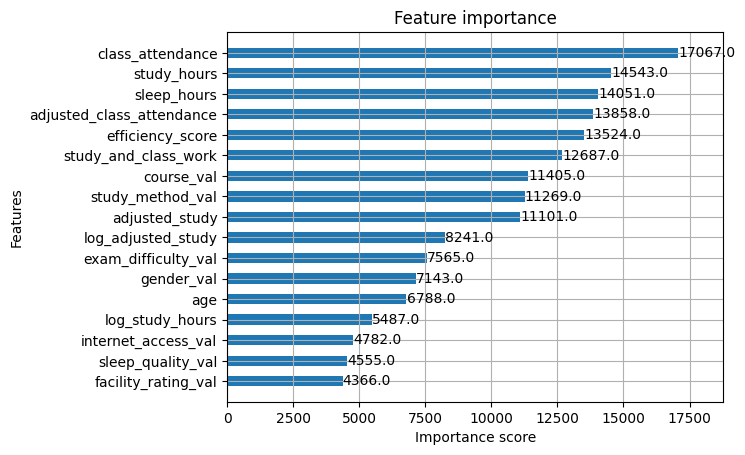

In [ ]:

plt.figure(figsize=(10, 15))

xgb.plot_importance(xgb_model, max_num_features=20, height=0.5)

plt.show()

Cat Boost

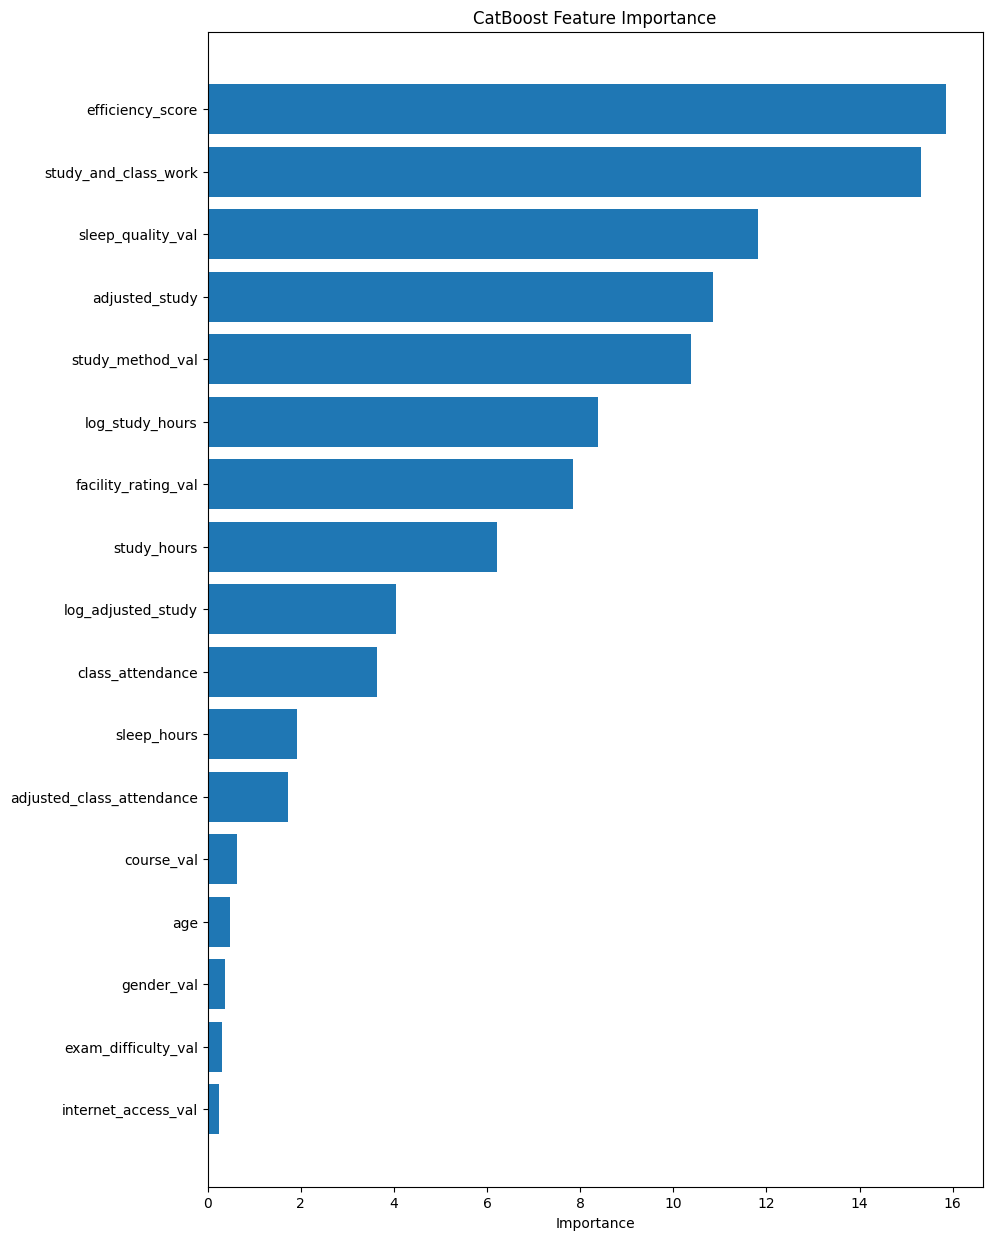

In [ ]:
feat_imp_cat = cat_model.get_feature_importance(prettified=True)

plt.figure(figsize=(10, 15))
plt.title("CatBoost Feature Importance")

top_20_cat = feat_imp_cat.head(20).sort_values(by='Importances', ascending=True)

plt.barh(top_20_cat['Feature Id'], top_20_cat['Importances'])
plt.xlabel("Importance")
plt.show()

#### LightGBM

<Figure size 1000x1500 with 0 Axes>

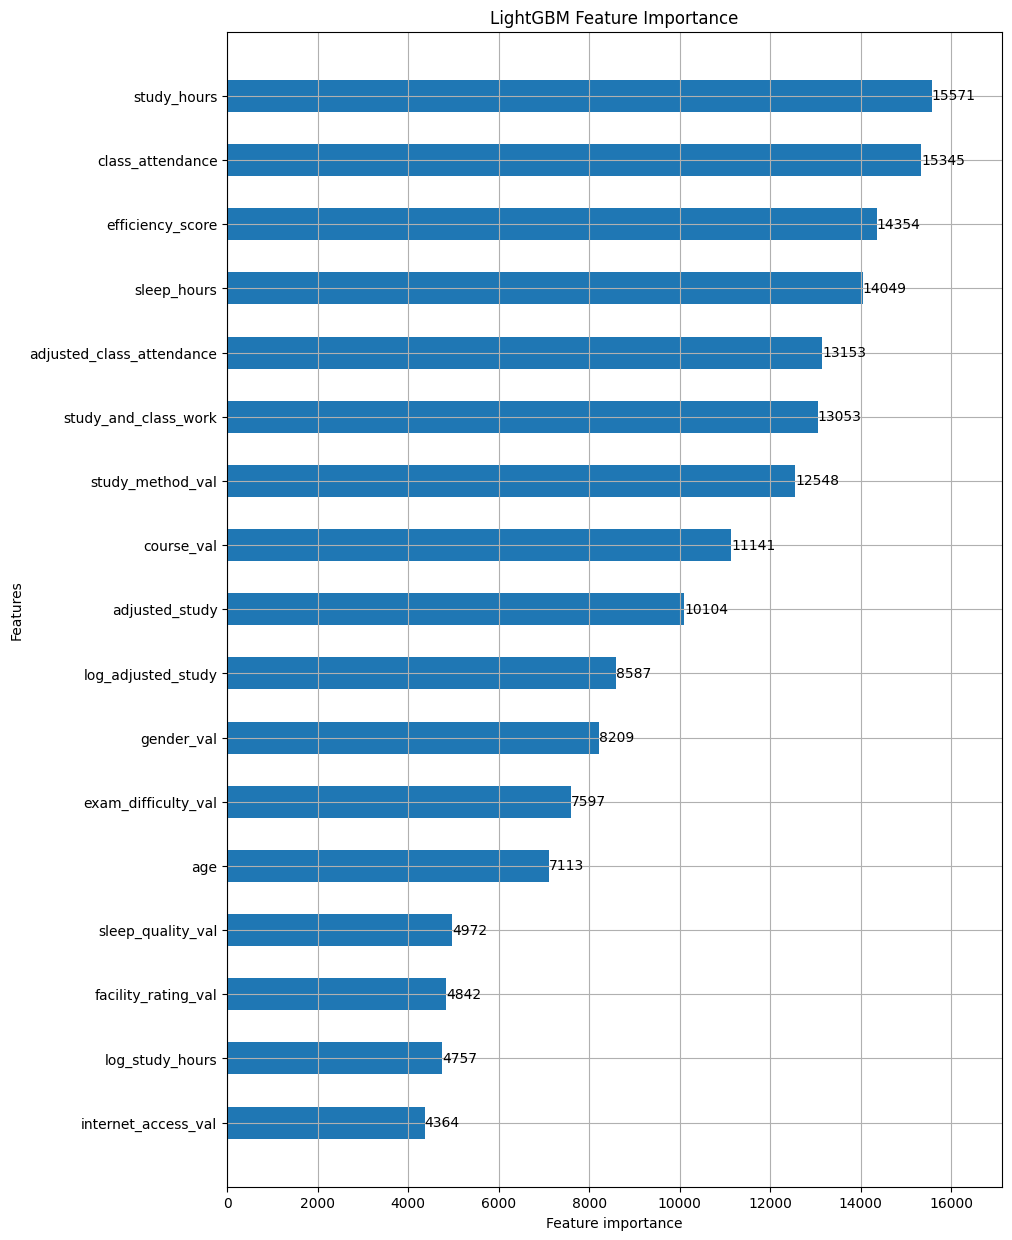

In [ ]:
plt.figure(figsize=(10, 15))

lgb.plot_importance(lgbm_model, max_num_features=20, height=0.5, figsize=(10, 15), title="LightGBM Feature Importance")

plt.show()